In [38]:
# Import and initialize
from jax.config import config
config.update('jax_platform_name', 'cpu') #Otherwise jax displays an annoying warning every time
config.update('jax_disable_jit', False)
config.update('jax_enable_x64', True)

import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 14}
matplotlib.rc('font', **font)
from NODE_fns import forward_pass_nobias, forward_pass, NODE_old as NODE
from jax import grad, random, jit, vmap
from functools import partial
import jax.example_libraries.optimizers as optimizers
from jax.lax import cond, scan
from jax.experimental.ode import odeint
from diffrax import diffeqsolve, ODETerm, SaveAt, Heun as mysolver
import pickle
key = random.PRNGKey(0)
import pandas as pd

# from scipy.integrate import odeint

In [203]:
def init_params_positivebias(layers):
    global key
    Ws = []
    for i in range(len(layers) - 1):
        std_glorot = np.sqrt(2/(layers[i] + layers[i + 1]))
        key, subkey = random.split(key)
        Ws.append(random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
    b = np.zeros(layers[i + 1])
    return Ws, b

def init_Phi_params():
    layers = [1,2,3,1]
    NODE3_params = init_params_positivebias(layers)
    NODE4_params = init_params_positivebias(layers)
    NODE5_params = init_params_positivebias(layers)
    Phi_params = [NODE3_params, NODE4_params, NODE5_params]
    return Phi_params

def dPhi_NODE(taui, Phi_params):
    # NODE1_params, NODE2_params, NODE3_params, NODE4_params, NODE5_params = Phi_params
    NODE3_params, NODE4_params, NODE5_params = Phi_params
    tau1 = taui[0]
    tau2 = taui[1]
    tau3 = taui[2]

    I3 = tau1 + tau2 + tau3
    I4 = tau1**2 + tau2**2 + tau3**2 + 2*tau1*tau2 + 2*tau1*tau3 + 2*tau2*tau3
    I5 = tau1**2 + tau2**2 + tau3**2 -   tau1*tau2 -   tau1*tau3 -   tau2*tau3

    N3 = NODE(I3, NODE3_params)
    N4 = NODE(I4, NODE4_params) #I1^2
    N5 = NODE(I5, NODE5_params) #I1^2 - 3I2

    N1 = N2 = 0

    Phi1 = N1 + N2 + N3 + 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau1 - tau2 - tau3) #dphi/dtau1
    Phi2 =      N2 + N3 + 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau2 - tau1 - tau3)
    Phi3 =           N3 + 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau3 - tau1 - tau2)

    return [Phi1, Phi2, Phi3]
dPhi_vmap = vmap(dPhi_NODE, in_axes=(0, None), out_axes = (0))

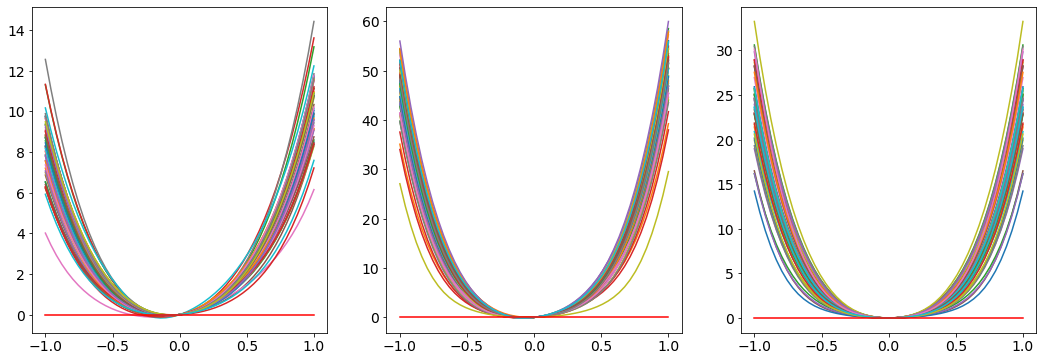

In [319]:
# Uniaxial loading
tau11 = onp.linspace(-1,1)
tau = onp.repeat(onp.array([onp.zeros([3,3])]),50, axis=0)
tau[:,0,0] = tau11

fig, ax = plt.subplots(1,3,figsize=(18,6))
ncurve = 50
curves1 = []
for i in range(ncurve):
    key, subkey = random.split(key)
    Phi_params = init_Phi_params()
    dPhi = dPhi_vmap([tau[:,0,0], tau[:,1,1], tau[:,2,2]], Phi_params)
    dPhi = dPhi[0]*tau[:,0,0] + dPhi[1]*tau[:,1,1] + dPhi[2]*tau[:,2,2]
    ax[0].plot(tau11, dPhi)
    curves1.append(dPhi)
ax[0].plot([-1,1], [0,0], 'r')

# Equibiaxial loading
tau[:,1,1] = tau11
curves2 = []
for i in range(ncurve):
    key, subkey = random.split(key)
    Phi_params = init_Phi_params()
    dPhi = dPhi_vmap([tau[:,0,0], tau[:,1,1], tau[:,2,2]], Phi_params)
    dPhi = dPhi[0]*tau[:,0,0] + dPhi[1]*tau[:,1,1] + dPhi[2]*tau[:,2,2]
    ax[1].plot(tau11, dPhi)
    curves2.append(dPhi)
ax[1].plot([-1,1], [0,0], 'r')

# Pure shearing
tau = onp.repeat(onp.array([onp.zeros([3,3])]),50, axis=0)
tau[:,0,1] = tau11
tau[:,1,0] = tau11
curves3 = []
for i in range(ncurve):
    key, subkey = random.split(key)
    Phi_params = init_Phi_params()
    taui = onp.linalg.eigvals(tau)
    dPhi = dPhi_vmap(taui, Phi_params)
    dPhi = dPhi[0]*taui[:,0] + dPhi[1]*taui[:,1] + dPhi[2]*taui[:,2]
    ax[2].plot(tau11, dPhi)
    curves3.append(dPhi)
ax[2].plot([-1,1], [0,0], 'r')


In [325]:
# Save for tikz

# Panel A
header = ['x']
for i in range(ncurve):
    header.append('y{}'.format(str(i)))
a = np.array([tau11, *curves1]).T
df = pd.DataFrame(a, columns = header)
df.to_csv('tikz_data/fig_odetrj_data/fig_2ndlaw_A.csv', index=False, sep=' ')

# Panel B
a = np.array([tau11, *curves2]).T
df = pd.DataFrame(a, columns = header)
df.to_csv('tikz_data/fig_odetrj_data/fig_2ndlaw_B.csv', index=False, sep=' ')

# Panel C
a = np.array([tau11, *curves3]).T
df = pd.DataFrame(a, columns = header)
df.to_csv('tikz_data/fig_odetrj_data/fig_2ndlaw_C.csv', index=False, sep=' ')

In [408]:
def init_params(layers, key):
  Ws = []
  bs = []
  for i in range(len(layers) - 1):
    std_glorot = np.sqrt(2/(layers[i] + layers[i + 1]))
    key, subkey = random.split(key)
    Ws.append(random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
    bs.append(np.zeros(layers[i + 1]))
  return [Ws, bs]

def forward_pass(H, params):
    Ws, b = params
    N_layers = len(Ws)
    for i in range(N_layers - 1):
        H = np.matmul(H, Ws[i]) + b[i]
        H = np.tanh(H)
    Y = np.matmul(H, Ws[-1]) + b[-1]
    return Y

# Train a FFNN to predict dPhi/dtaui
def dPhi_gov(tau_i, etad = 1360, etav = 175000): 
    tau1, tau2, tau3 = tau_i
    trtau = tau1 + tau2 + tau3
    dphidtau1 = 2*(1/3/etad + 1/9/etav)*trtau - 1/etad*(tau2+tau3)
    dphidtau2 = 2*(1/3/etad + 1/9/etav)*trtau - 1/etad*(tau1+tau3)
    dphidtau3 = 2*(1/3/etad + 1/9/etav)*trtau - 1/etad*(tau1+tau2)
    return [dphidtau1, dphidtau2, dphidtau3]
dPhi_gov_vmap = vmap(dPhi_gov, in_axes=(0, None, None), out_axes=(0))

layers = [3, 5, 5, 3]
def loss(params, taui):
    dPhi_gt = dPhi_gov(taui)
    dPhi_pr = forward_pass(taui, params)
    loss = np.mean((np.array(dPhi_gt)-np.array(dPhi_pr))**2)
    return  loss
loss_vmap = vmap(loss, in_axes=(None, 0))

def batch_loss(params, taui):
    return np.mean(loss_vmap(params, taui))

@partial(jit)
def step(i, opt_state, X_batch):
    params = get_params(opt_state)
    g = grad(batch_loss)(params, X_batch)
    return opt_update(i, g, opt_state)

def train(loss, X, opt_state, key, nIter = 10000, batch_size = 10):
    train_loss = []
    val_loss = []
    for it in range(nIter+1):
        key, subkey = random.split(key)
        idx_batch = [random.choice(subkey, X.shape[0], shape = (batch_size,), replace = False)]
        opt_state = step(it, opt_state, X[idx_batch])         
        if it%10000 == 0 or it == nIter:
            params = get_params(opt_state)
            train_loss_value = batch_loss(params, X)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss

taui = onp.mgrid[-3:3:10j, -3:3:10j, -3:3:10j]
taui = taui.reshape([3,-1]).transpose()
taui = -onp.sort(-taui)

FFNN_params = init_params(layers, key)
opt_init, opt_update, get_params = optimizers.adam(5.e-6)
opt_state = opt_init(FFNN_params)
FFNN_params, train_loss, val_loss = train(loss, taui, opt_state, key, nIter = 300000, batch_size = 100)

/var/folders/mb/kzyvgqjd3016ccxvv4d8kg2r0000gn/T/ipykernel_51801/1491466672.py:53: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  opt_state = step(it, opt_state, X[idx_batch])


it 0, train loss = 2.430958e-01
it 10000, train loss = 5.386089e-02
it 20000, train loss = 1.113585e-02
it 30000, train loss = 2.880091e-03
it 40000, train loss = 1.036922e-03
it 50000, train loss = 4.153465e-04
it 60000, train loss = 1.704439e-04
it 70000, train loss = 6.541269e-05
it 80000, train loss = 2.287506e-05
it 90000, train loss = 8.826430e-06
it 100000, train loss = 4.809745e-06
it 110000, train loss = 3.135491e-06
it 120000, train loss = 2.177516e-06
it 130000, train loss = 1.563397e-06
it 140000, train loss = 1.154238e-06
it 150000, train loss = 8.648201e-07
it 160000, train loss = 6.631242e-07
it 170000, train loss = 5.209007e-07
it 180000, train loss = 4.180634e-07
it 190000, train loss = 3.425003e-07
it 200000, train loss = 2.870764e-07
it 210000, train loss = 2.473994e-07
it 220000, train loss = 2.148576e-07
it 230000, train loss = 1.913250e-07
it 240000, train loss = 1.717453e-07
it 250000, train loss = 1.578499e-07
it 260000, train loss = 1.456400e-07
it 270000, trai

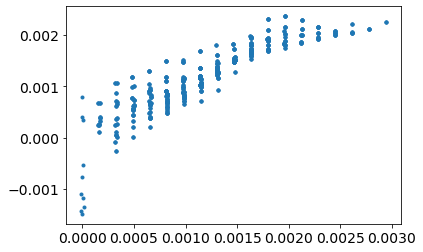

In [410]:
dPhi_gt = []
dPhi_pr = []
for i in range(taui.shape[0]):
    dPhi_gt.append(dPhi_gov(taui[i]))
    dPhi_pr.append(forward_pass(taui[i], FFNN_params))

dPhi_gt = np.array(dPhi_gt)
dPhi_pr = np.array(dPhi_pr)
plt.plot(dPhi_gt[:,0], dPhi_pr[:,0], '.')

/Users/vt/miniforge3/envs/jax/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/vt/miniforge3/envs/jax/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/vt/miniforge3/envs/jax/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/vt/miniforge3/envs/jax/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/vt/miniforge3/envs/jax/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/User

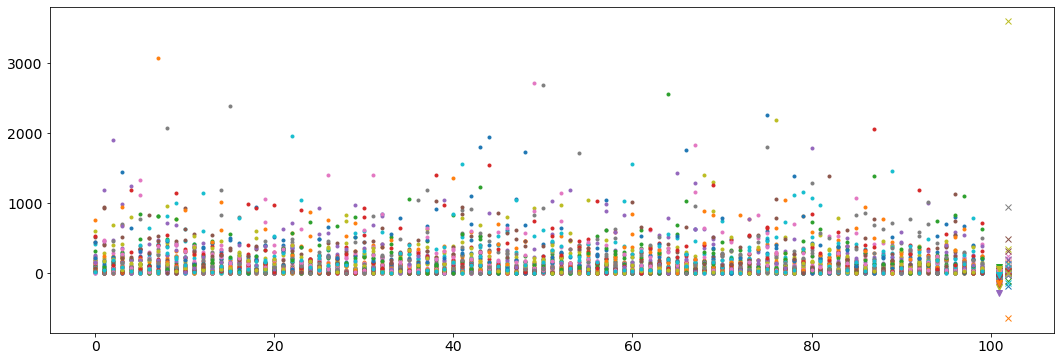

In [469]:
# Random stress tensors
fig, ax = plt.subplots(figsize=(18,6))

allpoints = []
for i in range(100):
    key, subkey = random.split(key)
    Phi_params = init_Phi_params()
    thisnodepoints = []
    for j in range(50):
        tau = onp.random.normal(size=[3,3])
        taui = onp.array([onp.linalg.eigvals(tau)])
        dPhi = dPhi_vmap(taui, Phi_params)
        dPhi = dPhi[0]*taui[:,0] + dPhi[1]*taui[:,1] + dPhi[2]*taui[:,2]
        ax.plot(i,dPhi, '.');
        thisnodepoints.append(dPhi)
    allpoints.append(thisnodepoints)

thisnodepoints = []
for i in range(50):
    tau = onp.random.normal(size=[3,3])
    taui = onp.array([onp.linalg.eigvals(tau)])
    dPhi = forward_pass(taui, FFNN_params)[0]
    dPhi = (dPhi[0]*taui[:,0] + dPhi[1]*taui[:,1] + dPhi[2]*taui[:,2])*4000
    ax.plot(102, dPhi, 'x')
    thisnodepoints.append(dPhi)
allpoints.append(thisnodepoints)

random_NN_params = init_params(layers, key)
thisnodepoints = []
for i in range(50):
    tau = onp.random.normal(size=[3,3])
    taui = onp.array([onp.linalg.eigvals(tau)])
    dPhi = forward_pass(taui, random_NN_params)[0]
    dPhi = (dPhi[0]*taui[:,0] + dPhi[1]*taui[:,1] + dPhi[2]*taui[:,2])*100
    ax.plot(101, dPhi, 'v')
    thisnodepoints.append(dPhi)
allpoints.append(thisnodepoints)

In [470]:
# Panel D
header = []
a = []
for i in range(100):
    header.append('x{}'.format(str(i)))
    a.append(np.ones(50)*i)
header.append('x2FFNN')
header.append('x1FFNN') # This is not a mistake.
a.append(np.ones(50)*102)
a.append(np.ones(50)*101)

for i in range(100):
    header.append('y{}'.format(str(i)))
header.append('y2FFNN')
header.append('y1FFNN') # This is not a mistake.

b = np.array(allpoints)[:,:,0]
a = np.vstack([a,b]).T
a = np.real(a)
df = pd.DataFrame(a, columns = header)
df.to_csv('tikz_data/fig_2ndlaw_data/fig_2ndlaw_D.csv', index=False, sep=' ')